# Shockley-Queisser Limit Calculator
Or more accurately the _detailed balance limit_ calculator

Based on the Mathematica script by Steve Byrnes. Original pdf explaning the script available here: http://sjbyrnes.com/sq.pdf, do check it out, if only for the correct pronunciation of 'Queisser'. 

From Steve's document:

> The Schockley-Queisser (SQ) limit is a famous limit on the maximal possible efficiency of solar cells, limited only by fundamental physics. It applies to most solar cell designs in the world, except for "tandem solar cells" and some additional obscure exceptions (discussed at the end of the document) [Check out the original pdf for this info]. The most important parameter in the SQ model is the bandgap of the semiconductor: If the gap is right, the efficiency can be up to 34%, if the gap is way off, the efficiency limit may be much smaller.

The efficiency predicted by the SQ limit **applies only to the solar spectrum**. This notebook first recreates the SQ limit calculation to verify the method, and then applies it to some artificial light sources. 

In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
# Loading data from text files
# You may have to modify the next line if running the notebook locally
module_dir = os.path.dirname(os.path.abspath('.\\Jupyter\\')) + os.sep

# the ASTMG173.csv file holds the standard AM1.5 solar spectrum
# You can find the original at rredc.nrel.gov/solar/spectra/am1.5
spectrum = np.loadtxt(module_dir + 'ASTMG173.csv', delimiter=',', skiprows=1)

Let's check if what we loaded looks alright

Total spectrum irriadiance:  1000.47070361 W/m^2


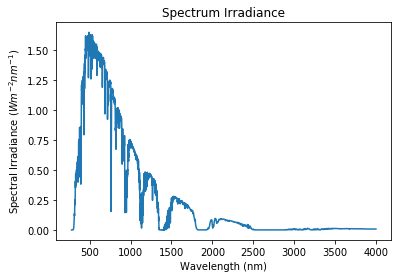

In [4]:
plt.plot(spectrum[:, 0], spectrum[:, 1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}nm^{-1}$)')
plt.title('Spectrum Irradiance')
original_irradiance = np.trapz(spectrum[:, 1], spectrum[:, 0])
print 'Total spectrum irriadiance: ', original_irradiance, 'W/m^2'

The ASTM AM1.5 spectrum is normalised such that it has an irradiance of 1000 $Wm^{-2}$. Close enough.

In [5]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant')

In [6]:
# Globals
Tcell = 300  # Kelvin
# Energy Gap
# The energy gap enetered here will be highlighted on upcoming plots. 
# Default is set to silicon bandgap 1.1eV
Egap = 1.1  #electron volts
# Silicon = 1.1eV

First let's preprocess the data a little. Original spectrum data is in $Wm^{-2}nm^{-1}$. To work out the SQ limit it will make it a little easier if we convert it to $N_p m^{-2} s^{-1}dE$, that is number of photons per square metre, per second, per energy gap.

Key equations:

$ E = \frac{hc}{\lambda}$ - Energy of a photon in **Joules**

$ E(eV) = \frac{hc}{\lambda e}$ - Energy of a photon in **electron-volts**

$ E_e = N_p \times e \times E(eV) $ - Irradiance in watts per square metre

with $e$ being the charge on an electron.

In [7]:
# A helper function that will do the job for us
def convert_spectrum(spectrum):
    """
    Spectrum input:
        y: Irradiance (W/m2/nm)
        x: Wavelength (nm)
    Converted otput:
        y: Number of photons (Np/m2/s/dE)
        x: Energy (eV)
    """
    converted = np.copy(spectrum)
    converted[:, 0] = converted[:, 0] * 1e-9  # wavelength to m
    converted[:, 1] = converted[:, 1] / 1e-9  # irradiance to W/m2/m (from W/m2/nm)

    E = h * c / converted[:, 0]
    d_lambda_d_E = h * c / E**2
    converted[:, 1] = converted[:, 1] * d_lambda_d_E * e / E
    converted[:, 0] = E / e
    return converted

If everything went okay this should be pretty close to the number from before
Original  1000.47070361  W/m^2	Converted  1000.47073062  W/m^2


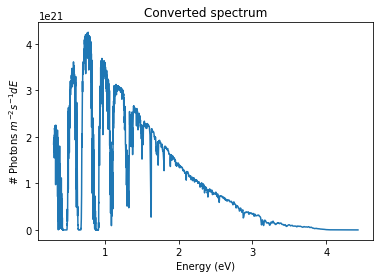

In [8]:
# Let's use the function, convert the input from the text file and have a look at it
photon_spectrum = convert_spectrum(spectrum)

plt.plot(photon_spectrum[:,0], photon_spectrum[:,1])
plt.xlabel('Energy (eV)')
plt.ylabel('# Photons $m^{-2}s^{-1}dE$')
plt.title('Converted spectrum')

# Irradiance check
photon_irradiance = np.trapz(photon_spectrum[::-1, 1] * photon_spectrum[::-1, 0],
                          photon_spectrum[::-1, 0]) * e


print 'If everything went okay this should be pretty close to the number from before'
print 'Original ', original_irradiance, ' W/m^2\tConverted ', photon_irradiance, ' W/m^2'

Couple things to note about this plot:

* The x-axis is _reversed_. Kind of. What used to be short wavelength ultraviolet and blue photons on the left hand side is now between 3 and 4 eV on the right hand side.
* Long wavelengths will appear much larger on the photon count plot. This is simply because red/infrared photons have much less energy. To deliver the same amount of irradiance, **many** more infrared photons are needed than if blue photons are used.

### Photons above bandgap
Only photons which have an energy above the bandgap of the material in question can promote electrons to the conduction band. Let's plot their number as a function of the bandgap.

In [9]:
def photons_above_bandgap(egap, spectrum):
    """Counts number of photons above given bandgap"""
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1], x[::-1])


def photons_above_bandgap_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = photons_above_bandgap(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])

    p_above_1_1 = photons_above_bandgap(Egap, spectrum)
    plt.plot([Egap], [p_above_1_1], 'ro')
    plt.text(Egap+0.05, p_above_1_1, '{}eV, {:.4}'.format(Egap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('# Photons $m^{-2}s^{-1}$')
    plt.title('Number of above-bandgap \nphotons as a function of bandgap')
    plt.show()

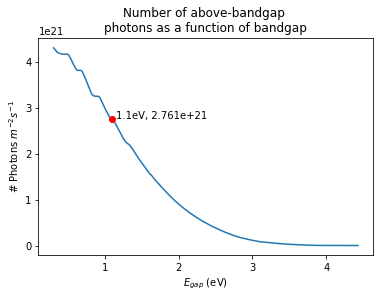

In [10]:
photons_above_bandgap_plot(photon_spectrum)

### Radiative Recombination
From Steve's explanation:

**Recombination rate**
> In the best possible case, the only cause of electron-hole-pair recombination is radiative recombination. Radiative recombination occurs when an electron and hole collide, so it depends on how many electrons and holes there are, or more specifically is depends on the electron and hole QFLs [Quasi-Fermi Level]

** Recombination rate when electron QFL = hole QFL**

> This is the case where electron QFL = hole QFL throughout the semiconductor. An example is the solar cell at zero bias in the dark. Then it’s in thermal equilibrium and its radiation can be calculated by the blackbody formula -- more specifically, assuming it’s a perfect blackbody above the bandgap and white-body below the bandgap. We also assume isotropic radiation from the top surface, and a mirror on the bottom surface.

> Let RR0 be the "Radiative Recombination rate at 0 QFL splitting", (per solar-cell area). By the blackbody formula:

> $RR0 = \frac{2\pi}{c^2h^3} \int_{E_{gap}}^{\infty}{\frac{E^2}{\exp{\frac{E}{kR}-1}}dE}$

In [11]:
def rr0(egap, spectrum):
    k_eV = k / e
    h_eV = h / e
    const = (2 * np.pi) / (c**2 * h_eV**3)

    k_eV = k / e
    E = spectrum[::-1, ]  # in increasing order of bandgap energy
    egap_index = np.where(E[:, 0] >= egap)
    numerator = E[:, 0]**2
    exponential_in = E[:, 0] / (k_eV * Tcell)
    denominator = np.exp(exponential_in) - 1
    integrand = numerator / denominator

    integral = np.trapz(integrand[egap_index], E[egap_index, 0])

    result = const * integral
    return result[0]

Again from Steve:

**Recombination rate when electron QFL and hole QFL are split**

>By kinetic theory, the radiative recombination rate is proportional to the product of electron concentration and hole concentration, p? n. If you move the electron QFL up towards the conduction band by energy E, the electron concentration increases by Exp[- E/kT]. Likewise, if you move the hole QFL down towards the valence band by E, the hole concentration increases by Exp[E/kT]. Either way, pn [is proportional] to Exp[E/kT], where E is the QFL energy splitting.

>In the best possible case, the QFL splitting is equal to the external voltage (in reality, it may be larger than the external voltage). Therefore, the lowest possible radiative recombaniton rate is:

>Recombination rate $= e \times RR0 \times exp{(\frac{eV}{kT})}$


There are some caveats for really small bandgaps <200meV where a more accurate expression is needed so beware. Check out the corresponding section in Steve's document for details. 

In [12]:
def recomb_rate(egap, spectrum, voltage):
    print 'recomb rate'
    return e * rr0(egap, spectrum) * np.exp(e * voltage / (k * Tcell))

### J and V versus bandgap
The short circuit current density $J$ and open circuit voltage $V$ for an ideal solar cell.

From Steve: 

> The current is from the electron-hole pairs that are created but which don’t recombine. In the best case, all the solar photons possible are absorbed, while none recombine except radiatively. This gives:

> $ J = e (N_p - RR0 \times e^{\frac{eV}{kT}}-1) $

> where $J$ is the current per unit area, and $V$ is the forward bias on the junction[, and $N_p$ is the number of solar photons above the bandgap]. The "-1" on the right accounts for spontaneous generation of e-h pairs through thermal fluctuations at 300K. I will leave out the "-1" below because $RR0 << N_p$

In [13]:
def current_density(egap, spectrum, voltage):
    # print 'current_density'
    # print photons_above_bandgap(egap, spectrum), 'photons above bandgap'
    # print e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum)), 'photons above bandgap - rr0'
    return e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum) * np.exp(e * voltage / (k * Tcell)))


def jsc(egap, spectrum):
    # print 'jsc'
    return current_density(egap, spectrum, 0)


def voc(egap, spectrum):
    # print 'voc'
    return (k * Tcell / e) * np.log(photons_above_bandgap(egap, spectrum) / rr0(egap, spectrum))

In [14]:
# For an ideal solar cell these will be
print 'A material with a bandgap of %.2f will have an:' % Egap
print 'Ideal short circuit current: ', jsc(1.1, photon_spectrum), 'A/m^2'
print 'Ideal open circuit  voltage: ', voc(1.1, photon_spectrum), 'V'

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  442.329590538 A/m^2
Ideal open circuit  voltage:  0.857871316968 V


In [15]:
def ideal_jsc_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = jsc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    e_gap = 1.1
    p_above_1_1 = jsc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$J_{SC}$ $Am^{-2}$')
    plt.title('Ideal short-circuit current')


def ideal_voc_plot(spectrum):
    """Plot of the ideal open circuit voltage as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a[2:]:
        # print row
        row[1] = voc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    plt.plot(a[:, 0], a[:, 0])
    e_gap = 1.1
    p_above_1_1 = voc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$V_{OC}$ (V)')
    plt.xlim((0.5,3.5))
    plt.title('Ideal open-circuit voltage. Straight line is bandgap.')

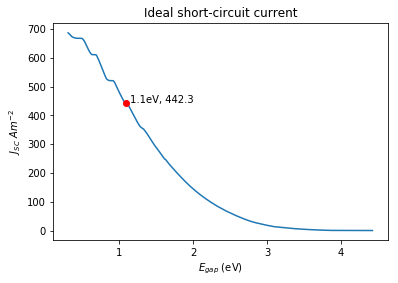

In [16]:
ideal_jsc_plot(photon_spectrum)

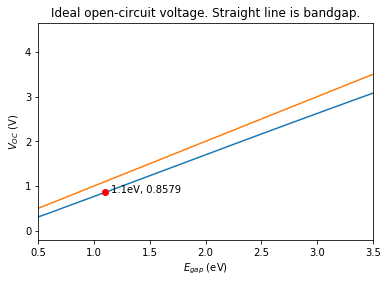

In [17]:
ideal_voc_plot(photon_spectrum)

### Maximum efficiency
With a method to find the ideal current and the ideal voltage, we can combine them to find the ideal power.

The efficiency of a solar cell is 

$\eta = \frac{IV}{E_e}$

where $I$ and $V$ are the current and voltage of the solar cell, and $E_e$ is the total irradiance incident on the cell. An IV curve of a solar cell looks like this:

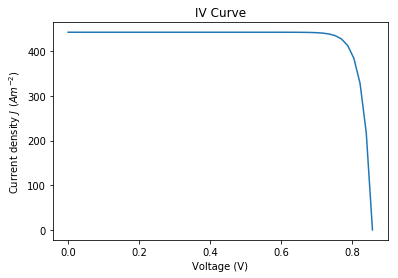

In [18]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, or the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)
    if power:
        p =  v * current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Power generated ($W$)')
        plt.title('Power Curve')
        plt.plot(v, p)
    else:
        i =  current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density $J$ ($Am^{-2}$)')
        plt.title('IV Curve')
        plt.plot(v, i)
    
iv_curve_plot(Egap, photon_spectrum)

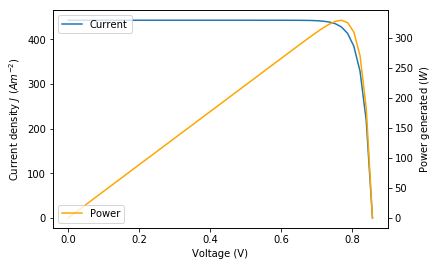

In [19]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, and the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)

    fig, ax1 = plt.subplots()
    p =  v * current_density(egap, spectrum, v)
    i =  current_density(egap, spectrum, v)
    
    ax1.plot(v, i)
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Current density $J$ ($Am^{-2}$)')
    ax1.legend(['Current'], loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(v, p, color='orange')
    ax2.set_ylabel('Power generated ($W$)')
    ax2.legend(['Power'], loc=3)
    return


iv_curve_plot(Egap, photon_spectrum)

The product of each point on the $IV$ curve will give the possible generated power. The power plot has a clear peak.

This is important for achieving the highest power generation efficiency. The cell needs to be operated at a specific operating point. Often this point is not the same as the operating point of a load the cell is supplying power to and special circuits are needed to maximise the power harvested from a solar cell.

To obtain the efficiency we need to find the peak power point on the power curve. Here's some helper functions to do that, and to calculate the efficiency $\eta$:

In [20]:
def v_at_mpp(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return v[index][0]


def j_at_mpp(egap, spectrum):
    return max_power(egap, spectrum) / v_at_mpp(egap, spectrum)


def max_power(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return max(v * current_density(egap, spectrum, v))


def max_eff(egap, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    # print photons_above_bandgap(egap, spectrum) * e
    return max_power(egap, spectrum) / irradiance

In [21]:
print 'For a cell with bandgap %.2f eV' % Egap
print 'Ideal efficiency is {:.4}%'.format(max_eff(Egap, photon_spectrum)*100)

For a cell with bandgap 1.10 eV
Ideal efficiency is 32.91%


To find the famous SQ limit curve, we need to maximise the ideal generated power over the bandgap energies. 

In [22]:
def sq_limit_plot(spectrum):
    # Plot the famous SQ limit
    a = np.copy(spectrum)
    # Not for whole array hack to remove divide by 0 errors
    for row in a[2:]:
        # print row
        row[1] = max_eff(row[0], spectrum)
    # Not plotting whole array becase some bad values happen
    plt.plot(a[2:, 0], a[2:, 1])
    e_gap = Egap
    p_above_1_1 = max_eff(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('SQ Limit')

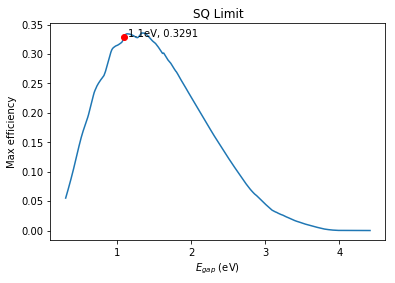

In [23]:
sq_limit_plot(photon_spectrum)

## Quantifying losses
So isn't all the energy available? One reason already explained is that photons below the bandgap energy cannot generate electron-hole pairs. This does not explain all of the power. 

From Steve:

>We split the incoming light power into five parts: 

>(A) Power converted into useful electricity; 

>(B) Power of below-bandgap photons, which is wasted power because these photons are not absorbed; 

>(C) Excess photon energy beyond the bandgap, which is wasted because the electron and hole just immediately relax to the band edges. For example, for a 1eV-bandgap semiconductor, a 3eV photon creates the same electron-hole pair as a 1.01eV photon. All the 2eV of extra energy carried by a 3eV photon in that case is wasted. 

>(D) Power lost due to electron-hole recombination at the max-power-point, which is wasted as heat; 

>(E) Power lost because the voltage of the cell at the max-power-point is less than the bandgap

Below are functions which calculate all these:

In [24]:
def excess_beyond_gap(egap, spectrum):
    """Loss due to energy beyond bandgap; lost as heat"""
    # find egap index
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1] * (x[::-1] - egap), x[::-1])


def energy_below_gap(egap, spectrum):
    """Energy of photons below the bandgap"""
    # find egap index
    indexes = np.where(spectrum[:, 0] < egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1] * x[::-1], x[::-1])


def mpp_recombination(egap, spectrum):
    """Loss due to recombination at the maximum power point"""
    return photons_above_bandgap(egap, spectrum) - j_at_mpp(egap, spectrum) / e


def mpp_v_less_than_gap(egap, spectrum):
    return j_at_mpp(egap, spectrum) * (egap - v_at_mpp(egap, spectrum))


def loss(egap, spectrum):
    """Returns a list with a breakdown of where the energy is lost"""
    solar_constant = np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    useful_electricity = max_eff(egap, spectrum)
    below_gap = energy_below_gap(egap, spectrum) * e / solar_constant
    beyond_gap = excess_beyond_gap(egap, spectrum) * e / solar_constant
    recomb = mpp_recombination(egap, spectrum) * e / solar_constant
    v_less = mpp_v_less_than_gap(egap, spectrum) / solar_constant
    return [useful_electricity, below_gap, beyond_gap, recomb, v_less]

In [25]:
def print_losses(egap, spectrum):
    """Print the breakdown of loss() nicely"""
    losses = loss(egap, spectrum)
    print 'Useful electricity: \t\t\t{:.4}%'.format(losses[0]*100)
    print 'Below bandgap losses: \t\t\t{:.4}%'.format(losses[1]*100)
    print 'Excess beyond gaplosses:\t\t{:.4}%'.format(losses[2]*100)
    print 'Recombination losses: \t\t\t{:.4}%'.format(losses[3]*100)
    print 'MPP Voltage less than gap losses: \t{:.4}%'.format(losses[4]*100)
    print 'Total should be close to 100%: \t\t{:.4}%'.format(sum(losses)*100)
    
print_losses(Egap, photon_spectrum)

Useful electricity: 			32.91%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.496%
MPP Voltage less than gap losses: 	14.08%
Total should be close to 100%: 		99.84%


Making a plot out of the losses. This function takes a while to evaluate.

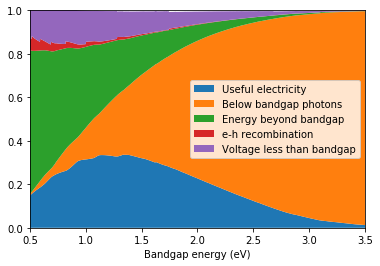

In [26]:
def loss_plot(spectrum):
    gaps = spectrum[2:,0]

    a_arr = np.empty_like(gaps)
    b_arr = np.empty_like(gaps)
    c_arr = np.empty_like(gaps)
    d_arr = np.empty_like(gaps)
    e_arr = np.empty_like(gaps)
    
    for index, gap in enumerate(gaps):
        q,w,e,r,t = loss(gap, spectrum)
        a_arr[index] = q
        b_arr[index] = w
        c_arr[index] = e
        d_arr[index] = r
        e_arr[index] = t
    
    plt.xlabel('Bandgap energy (eV)')
    plt.stackplot(gaps, [a_arr,b_arr,c_arr,d_arr,e_arr])
    plt.xlim(0.5,3.5)
    plt.ylim(0,1)
    labels = ['Useful electricity', 
          'Below bandgap photons', 
          'Energy beyond bandgap', 
          'e-h recombination', 
          'Voltage less than bandgap']
#     plt.legend(labels, loc='upper left', bbox_to_anchor=(1,1))
    plt.legend(labels, loc=7)
    
loss_plot(photon_spectrum)

The plot is only really valid where the sum is close to 1. For low bandgap energies <200meV the total losses add up to more than 1 because of the approximation used previusly.

c:\python27\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


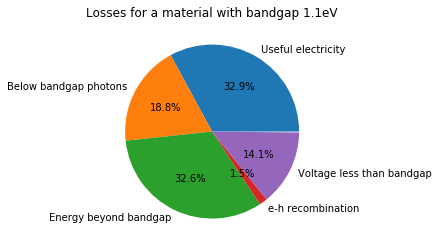

In [27]:
def plot_pie_breakdown(spectrum):
    losses_11eV = loss(Egap, spectrum)
    labels = ['Useful electricity', 
              'Below bandgap photons', 
              'Energy beyond bandgap', 
              'e-h recombination', 
              'Voltage less than bandgap']
    plt.pie(losses_11eV, labels=labels, autopct='%.1f%%')
    plt.title('Losses for a material with bandgap {}eV'.format(Egap))
    plt.axes().set_aspect('equal')
    plt.show()
    
plot_pie_breakdown(photon_spectrum)

# Exploring effect of irradiance level on the efficiency
Whether under the same spectral distribution but lower total irradiance the efficiency is different.

Let's do this for sunlight and scale it to a few different total irradiances. We already have the standard reference case of 1000$Wm^{-2}$, so let's try 100, 10, and 1. First we need a general method of scaling the spectrum to whatever total power we want.

In [28]:
def normalise_power(spectrum):
    result = np.copy(spectrum)
    power = np.trapz(result[:,1], result[:,0])
    result[:,1] /= power
    return result

def denormalise_power(spectrum, power):
    result = np.copy(spectrum)
    result[:,1] *= power
    return result

In [29]:
spectrum_100W = denormalise_power(normalise_power(spectrum), 100)
spectrum_10W = denormalise_power(normalise_power(spectrum), 10)
spectrum_1W = denormalise_power(normalise_power(spectrum), 1)
photon_spectrum_100W = convert_spectrum(spectrum_100W)
photon_spectrum_10W = convert_spectrum(spectrum_10W)
photon_spectrum_1W = convert_spectrum(spectrum_1W)

1000W
Useful electricity: 			32.91%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.496%
MPP Voltage less than gap losses: 	14.08%
Total should be close to 100%: 		99.84%

100W
Useful electricity: 			30.34%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.892%
MPP Voltage less than gap losses: 	16.21%
Total should be close to 100%: 		99.8%

10W
Useful electricity: 			27.8%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.336%
MPP Voltage less than gap losses: 	19.37%
Total should be close to 100%: 		99.85%

1W
Useful electricity: 			25.3%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.771%
MPP Voltage less than gap losses: 	21.39%
Total should be close to 100%: 		99.81%


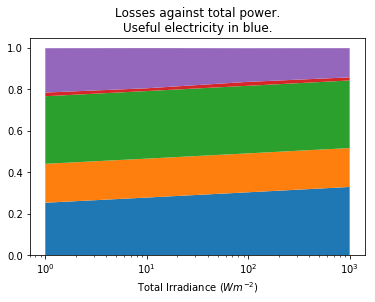

In [30]:
print '1000W'
print_losses(1.1, photon_spectrum)
print '\n100W'
print_losses(1.1, photon_spectrum_100W)
print '\n10W'
print_losses(1.1, photon_spectrum_10W)
print '\n1W'
print_losses(1.1, photon_spectrum_1W)

x = [1, 10, 100, 1000]
a_arr = np.empty_like(x)
b_arr = np.empty_like(x)
c_arr = np.empty_like(x)
d_arr = np.empty_like(x)
e_arr = np.empty_like(x)
w1 = loss(1.1, photon_spectrum_1W)
w2 = loss(1.1, photon_spectrum_10W)
w3 = loss(1.1, photon_spectrum_100W)
w4 = loss(1.1, photon_spectrum)

a_arr = [w1[0], w2[0], w3[0], w4[0]]
b_arr = [w1[1], w2[1], w3[1], w4[1]]
c_arr = [w1[2], w2[2], w3[2], w4[2]]
d_arr = [w1[3], w2[3], w3[3], w4[3]]
e_arr = [w1[4], w2[4], w3[4], w4[4]]

plt.stackplot(x, [a_arr, b_arr, c_arr, d_arr, e_arr])
plt.semilogx()
plt.xlabel('Total Irradiance ($Wm^{-2}$)')
plt.title('Losses against total power.\nUseful electricity in blue.')
plt.show()

Interestingly, the peak theoretical efficiency changes with the total irradiance on the material. At lower irradiances the cell operates at a voltage that is further away from the bandgap voltage, so that component of the loss increases. 

# Exploring other spectra
Artificial light sources have a different spectrum than sunlight. Below you can find a selection of some used for indoor lighting: white LEDs and fluorescent bulbs, and single colour LEDs in red, green, blue and infrared. All are normalised to have a relative peak of 1.

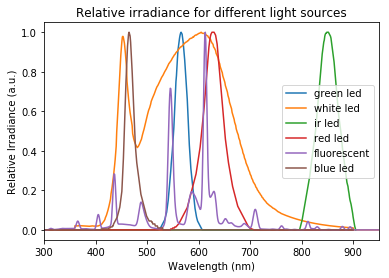

In [55]:
# Loading spectrum information
led_blue = np.loadtxt(module_dir + 'led_blue.csv', delimiter=',', skiprows=1)
led_red = np.loadtxt(module_dir + 'led_red.csv', delimiter=',', skiprows=1)
led_ir = np.loadtxt(module_dir + 'led_ir.csv', delimiter=',', skiprows=1)
led_green = np.loadtxt(module_dir + 'led_green.csv', delimiter=',', skiprows=1)
led_white = np.loadtxt(module_dir + 'led_white.csv', delimiter=',', skiprows=1)
fluor = np.loadtxt(module_dir + 'fluorescent.csv', delimiter=',', skiprows=1)

# Let's pack it up in a dict
spectra = {'white led': led_white,
           'red led': led_red,
           'green led': led_green,
           'blue led': led_blue,
           'ir led': led_ir,
           'fluorescent': fluor}

# Normalise to a peak of 1
def normalise_peak(spectrum):
    """overwrite original spectrum to have a peak of 1"""
    peak = max(spectrum[:,1])
    spectrum [:,1] = spectrum[:,1] / peak
    return


# And plotting it for comparison
for name, data in spectra.items():
    normalise_peak(data)
    plt.plot(data[:,0], data[:,1])
    
plt.legend(spectra.keys())
plt.xlabel('Wavelength (nm)')
plt.xlim((300,950))
plt.ylabel('Relative Irradiance (a.u.)')
plt.title('Relative irradiance for different light sources')
plt.show()

The total radiant power in each of those spectra will be very different. If we assume the units on the plot above are $Wm^{-2}nm^{-1}$, then we can compare the power delivered by those spectral distributions. Here's a summary:

In [56]:
for name, data in spectra.items():
    print '{} irradiance: {:.4}'.format(name, np.trapz(data[:,1], data[:,0]))

green led irradiance: 32.1
white led irradiance: 212.7
ir led irradiance: 52.91
red led irradiance: 53.48
fluorescent irradiance: 35.26
blue led irradiance: 25.51


### SQ Limit for a white LED

Let's focus on the white LED for now. So called _white_ LEDs do not natively emit _white_ light. (Partly because _white_ light doesn't exist). They rely on a blue LED and a special phosphorus coating. The LED emits high energy blue photons, some of them are absorbed in this coating and reemitted at longer wavelengths with lower energy-around the yellow/red region. This gives the LED a broadband spectrum which is perceived as _white_ light.

The relative distribution of the blue peak to the red peak gives the white LED it's colour temperature rating. Cool LEDs with high K ratings emit more blue light, while low K rated LEDs emit more of the red light. The spectrum here has both of them relatively equal which gives it a colour temperature around 4000K.

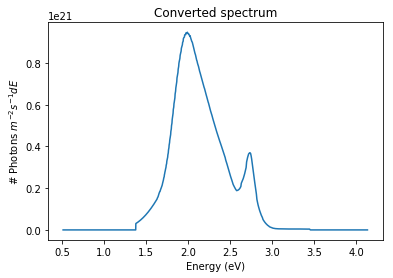

In [57]:
# Conversion to photon spectrum and plot
ledw_photon_spectrum = convert_spectrum(spectra['white led'])

plt.plot(ledw_photon_spectrum[:,0], ledw_photon_spectrum[:,1])
plt.xlabel('Energy (eV)')
plt.ylabel('# Photons $m^{-2}s^{-1}dE$')
plt.title('Converted spectrum')
plt.show()

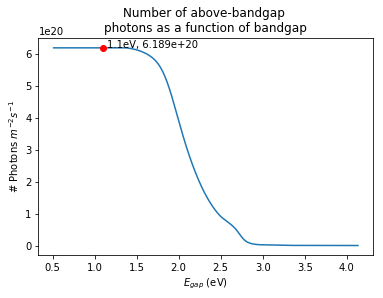

In [34]:
photons_above_bandgap_plot(ledw_photon_spectrum)

From the photon spectrum plot and the photons above bandgap plot you can see that pretty much all of the energy is above the bandgap of silicon 1.1eV. Not surprising since the white LED is supposed to emit light in the visible band which ends around 780nm while the silicon bandgap energy is equivalent to infrared photons.

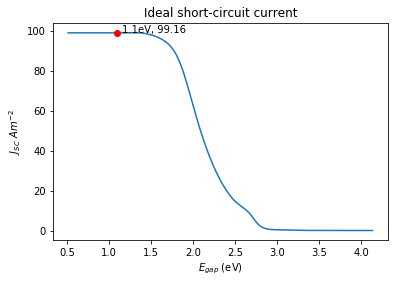

In [35]:
ideal_jsc_plot(ledw_photon_spectrum)

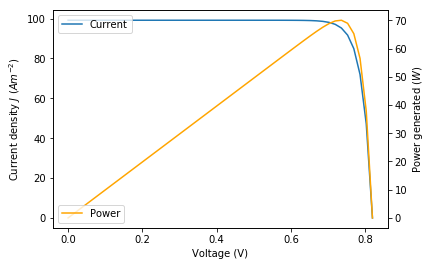

In [36]:
iv_curve_plot(Egap, ledw_photon_spectrum)

c:\python27\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
c:\python27\lib\site-packages\numpy\core\function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step
c:\python27\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


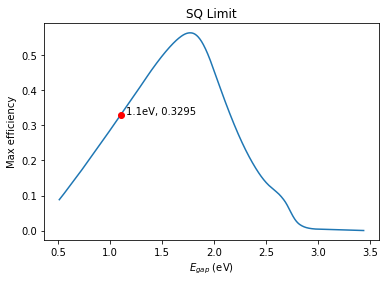

In [37]:
sq_limit_plot(ledw_photon_spectrum)

In [62]:
print_losses(1.1, ledw_photon_spectrum)

Useful electricity: 			32.95%
Below bandgap losses: 			0.0%
Excess beyond gaplosses:		48.71%
Recombination losses: 			1.838%
MPP Voltage less than gap losses: 	16.32%
Total should be close to 100%: 		99.82%


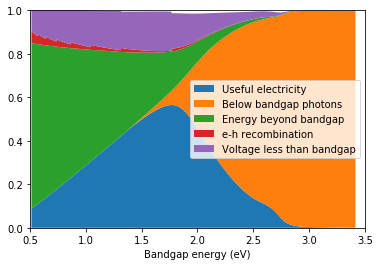

In [39]:
loss_plot(ledw_photon_spectrum[61:,:])

### SQ Limit for a fluorescent bulb
Let's do the same for the fluorescent light bulb.

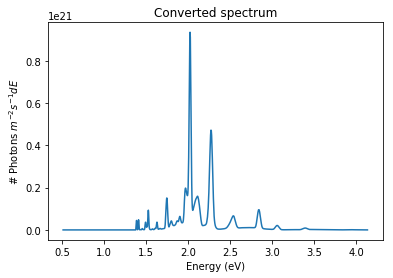

In [40]:
# Conversion to photon spectrum and plot
fluor_photon_spectrum = convert_spectrum(spectra['fluorescent'])

plt.plot(fluor_photon_spectrum[:,0], fluor_photon_spectrum[:,1])
plt.xlabel('Energy (eV)')
plt.ylabel('# Photons $m^{-2}s^{-1}dE$')
plt.title('Converted spectrum')
plt.show()

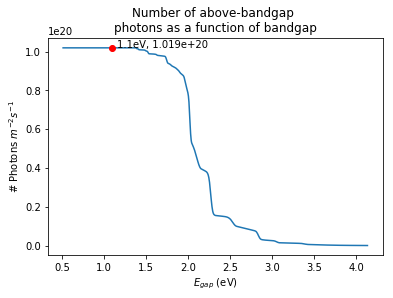

In [41]:
photons_above_bandgap_plot(fluor_photon_spectrum)

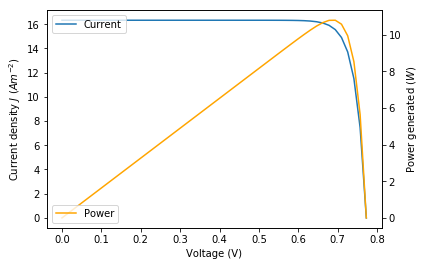

In [44]:
iv_curve_plot(Egap, fluor_photon_spectrum)

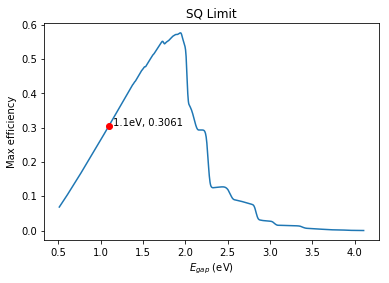

In [64]:
sq_limit_plot(fluor_photon_spectrum)

In [46]:
print_losses(Egap, fluor_photon_spectrum)

Useful electricity: 			30.61%
Below bandgap losses: 			0.0%
Excess beyond gaplosses:		49.06%
Recombination losses: 			2.194%
MPP Voltage less than gap losses: 	17.92%
Total should be close to 100%: 		99.78%


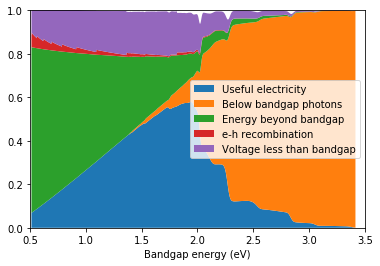

In [47]:
loss_plot(fluor_photon_spectrum[61:,:])

## Comparing sunlight, to LED, to fluorescent, for a 1.1eV material
Knowing that the efficiency can vary depending on the total irradiance, let's first define a more realsitic scenario for the comparison and normalise the spectra to some metric.

Here I suggest to normalise all three to the same **brightness**. How do we quantify brightness? 

### Illuminance, or how brightly are things lit
So far we have only used radiometric units which deal in physical quantities only, that is watts and photons. Perception of brightness and colour is much more subjective and will vary from person to person, but some standards exist and I'll introduce them here.

### Photometric Units
A different set of units is used to define the visible light spectrum in relation to how the human eye percieves light. The human eye responds differently to light of different colours. The response of a _standard_ eye is defined through the _photopic response function_, $V(\lambda)$. The response peaks around 550nm green light and rolls off smoothly down to the beginning of UV and IR. The function relates how bright a given colour will appear, to how much power in watts reaches the eye. In general, for something red and green to appear equally bright, the red object needs to emit twice the power of the green object. 

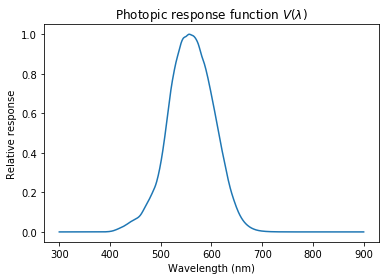

In [48]:
photopic = np.loadtxt(module_dir + 'photopic.csv', delimiter=',', skiprows=1)
plt.plot(photopic[:,0], photopic[:,1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative response')
plt.title('Photopic response function $V(\lambda$)')
plt.show()

To convert an irradiance spectrum to the photopic response we can use the following formula

$E_v = 683 \times \int E_{e\lambda} \times V(\lambda) d\lambda$

where $E_{e\lambda}$ is the spectral irradiance in watts per square metre, per unit wavelength. The end result is given in the units of _lux_. Lux are the general units of human perceptible brightness. For reference, direct sunlight is around 100klux, an overcast day may be 10klux, a brightly lit office could be between 500-1000lux, and typical home lighting may fall down to 100lux.

Let's check how bright our normalised spectra were:

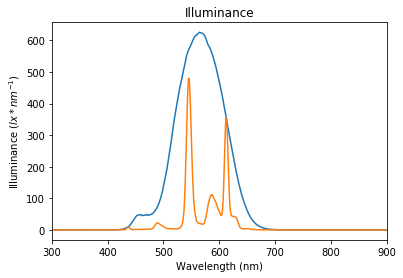

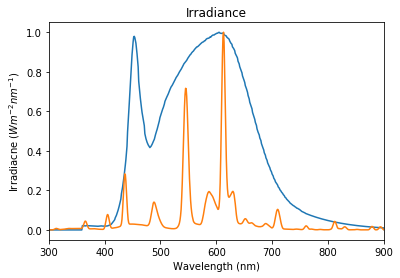

White LED Brightness: 65150.0976732 lux
Fluorescent bulb Brightness: 12549.2895088 lux


In [49]:
# Copying only the portion for which the photopic function is defined
led_white_photopic = np.copy(spectra['white led'][:601,:])
led_white_photopic[:,1] = led_white_photopic[:,1] * photopic[:,1] * 683

fluor_photopic = np.copy(spectra['fluorescent'][:601,:])
fluor_photopic[:,1] = fluor_photopic[:,1] * photopic[:,1] * 683

plt.plot(led_white_photopic[:,0], led_white_photopic[:,1])
plt.plot(fluor_photopic[:,0], fluor_photopic[:,1])
plt.xlabel('Wavelength (nm)')
plt.xlim((300,900))
plt.ylabel('Illuminance ($lx*nm^{-1}$)')
plt.title('Illuminance')
plt.show()

plt.plot(spectra['white led'][:,0], spectra['white led'][:,1])
plt.plot(spectra['fluorescent'][:,0], spectra['fluorescent'][:,1])
plt.xlabel('Wavelength (nm)')
plt.xlim((300,900))
plt.ylabel('Irradiacne ($Wm^{-2}nm^{-1}$)')
plt.title('Irradiance')
plt.show()

print 'White LED Brightness: {} lux'.format(np.trapz(led_white_photopic[:,1], led_white_photopic[:,0]))
print 'Fluorescent bulb Brightness: {} lux'.format(np.trapz(fluor_photopic[:,1], fluor_photopic[:,0]))

To set a specific brightness of the original power spectrum, we need to scale it by some factor dependent on the total lux. Below is a function that will do this.

In [50]:
def find_photopic_coefficient(wavelen):
    """Searches the photopic response function"""
    for row in photopic:
        if row[0] == wavelen:
            coeff = row[1]
            break
        else:
            coeff = 0
    return coeff


def denormalise_brightness(spectrum, illuminance):
    """Returns a spectrum in watts with a given illuminance in lux"""
    result = np.copy(spectrum)
    luminance_spectrum = np.copy(spectrum)
    for row in luminance_spectrum:
        row[1] = row[1] * find_photopic_coefficient(row[0]) * 683
    lux = np.trapz(luminance_spectrum[:,1], luminance_spectrum[:,0])
    coeff = illuminance / lux
    result[:, 1] *= coeff
    return result

Now we can equalise the sunlight, white LED and fluorescent bulb to the same brightness. let's do it for **1000 lux** and check how much power is in each one after we do this and see what these look like next to each other.

Sunlight power: 8.65068036685 W/m^2
White LED power: 3.26434466852 W/m^2
Fluorescent power: 2.80960368625 W/m^2


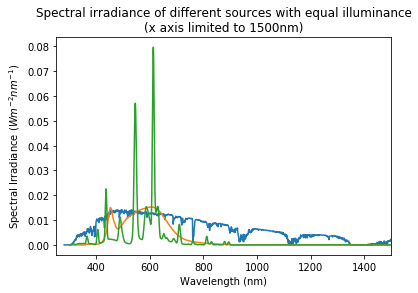

In [51]:
sun_1000lux = denormalise_brightness(spectrum, 1000)
led_1000lux = denormalise_brightness(spectra['white led'], 1000)
fluor_1000lux = denormalise_brightness(spectra['fluorescent'], 1000)

print 'Sunlight power: {} W/m^2'.format(np.trapz(sun_1000lux[:,1], sun_1000lux[:,0]))
print 'White LED power: {} W/m^2'.format(np.trapz(led_1000lux[:,1], led_1000lux[:,0]))
print 'Fluorescent power: {} W/m^2'.format(np.trapz(fluor_1000lux[:,1], fluor_1000lux[:,0]))

plt.plot(sun_1000lux[:,0], sun_1000lux[:,1])
plt.plot(led_1000lux[:,0], led_1000lux[:,1])
plt.plot(fluor_1000lux[:,0], fluor_1000lux[:,1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}nm^{-1}$)')
plt.title('Spectral irradiance of different sources with equal illuminance\n(x axis limited to 1500nm)')
plt.xlim(250,1500)
plt.show()

Sunlight is much more broadband and delivers a lot of its power through infrared. The two artificial sources are concentrated in the visible band, so can deliver the same brightness with less power overall. This is part of the reason why LED and fluorescent bulbs are more efficient when compared to incandescent bulbs.

Now we can compare the efficiency of an ideal cell under each of these. 

In [52]:
print 'Sunlight:'
print_losses(1.1, convert_spectrum(sun_1000lux))
print '\nWhite LED:'
print_losses(1.1, convert_spectrum(led_1000lux))
print '\nFluorescent:'
print_losses(1.1, convert_spectrum(fluor_1000lux))

Sunlight:
Useful electricity: 			27.64%
Below bandgap losses: 			18.77%
Excess beyond gaplosses:		32.59%
Recombination losses: 			1.36%
MPP Voltage less than gap losses: 	19.5%
Total should be close to 100%: 		99.85%

White LED:
Useful electricity: 			28.1%
Below bandgap losses: 			0.0%
Excess beyond gaplosses:		48.71%
Recombination losses: 			1.605%
MPP Voltage less than gap losses: 	21.42%
Total should be close to 100%: 		99.84%

Fluorescent:
Useful electricity: 			27.73%
Below bandgap losses: 			0.0%
Excess beyond gaplosses:		49.06%
Recombination losses: 			1.625%
MPP Voltage less than gap losses: 	21.42%
Total should be close to 100%: 		99.84%


* The biggest difference between the original SQ limit calculations for sunlight, and the artificial source calculations is the lack of below bandgap losses. Pretty obvious considering that there were not photons with energies below the bandgap present in the spectrum in the first place.
* The two artificial sources, white LED and fluorescent, have very similar loss contributions, despite the widely differing spectra. 
* In both cases the biggest loss contributor is the excess energy beyond the bandgap. The artificial  spectra have a significant amount of photons with energies much higher than the bandgap of 1.1, and that excess is simply lost because there is not difference between an electron generated by a photon with 1.101eV energy, or an energy of 2.0eV. In both cases the electron relaxes to the bandgap edge with the rest of the energy lost as heat.
* The efficiencies under all three are similar for a bandgap of 1.1eV.

c:\python27\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
c:\python27\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


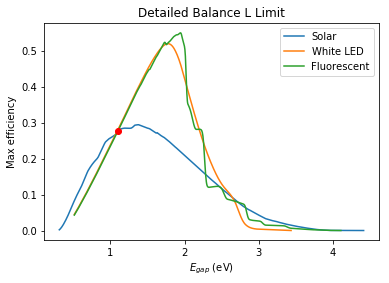

In [84]:
def sq_limit_plot(spectrum):
    # Plot the famous SQ limit
    a = np.copy(spectrum)
    # Not for whole array hack to remove divide by 0 errors
    for row in a[2:]:
        # print row
        row[1] = max_eff(row[0], spectrum)
    # Not plotting whole array becase some bad values happen
    plt.plot(a[2:, 0], a[2:, 1])
#     e_gap = Egap
#     p_above_1_1 = max_eff(e_gap, spectrum)
#     plt.plot([e_gap], [p_above_1_1], 'ro')
#     plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('Detailed Balance L Limit')

sq_limit_plot(convert_spectrum(sun_1000lux))
sq_limit_plot(convert_spectrum(led_1000lux))
sq_limit_plot(convert_spectrum(fluor_1000lux))
e_gap = Egap
p_above_1_1 = max_eff(e_gap, convert_spectrum(sun_1000lux))
plt.plot([e_gap], [p_above_1_1], 'ro') 

plt.legend(['Solar','White LED','Fluorescent'])
plt.show()

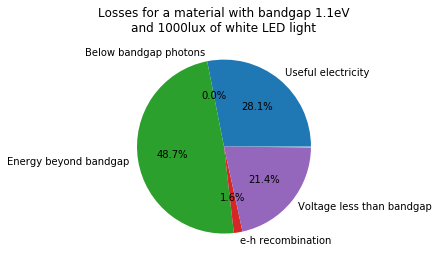

In [85]:
plt.pie(loss(Egap, convert_spectrum(led_1000lux)), 
        autopct='%.1f%%',
        labels=['Useful electricity', 'Below bandgap photons', 'Energy beyond bandgap', 'e-h recombination', 'Voltage less than bandgap'])
plt.title('Losses for a material with bandgap {}eV\nand 1000lux of white LED light'.format(Egap))
plt.axes().set_aspect('equal')
plt.show()